# DETR Model Evaluation Dashboard

This notebook evaluates the fine-tuned DETR model, reports metrics using MLOps-style visuals, and showcases predictions on test images. Feel free to extend it with additional analyses as the experiment evolves.


In [1]:
import importlib
import sys
import warnings
from collections.abc import Iterable
from pathlib import Path

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image

try:
    NOTEBOOK_DIR = Path(__file__).resolve().parent
except NameError:
    NOTEBOOK_DIR = Path.cwd().resolve()

PROJECT_ROOT = NOTEBOOK_DIR
for candidate in [NOTEBOOK_DIR, *NOTEBOOK_DIR.parents]:
    if (candidate / "src").exists():
        PROJECT_ROOT = candidate
        break
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

eval_utils = importlib.import_module("src.evaluation.evaluate_detr")

sns.set_theme(style="whitegrid")
warnings.filterwarnings(
    "ignore",
    message=r"for .*: copying from a non-meta parameter",
    category=UserWarning,
)
print(f"Project root: {PROJECT_ROOT}")

/root/animal_spotter/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Project root: /root/animal_spotter


In [2]:
MODEL_DIR = PROJECT_ROOT / "models" / "detr-finetuned"
TEST_IMAGES_DIR = PROJECT_ROOT / "data" / "images" / "test"
BATCH_SIZE = 2
METRIC_SCORE_THRESHOLD = 0.1
VISUAL_SCORE_THRESHOLD = 0.5

print(
    f"Model directory: {MODEL_DIR if MODEL_DIR.exists() else 'fallback HF checkpoint'}"
)
print(f"Test images directory: {TEST_IMAGES_DIR}")

model, processor, id2label = eval_utils.load_model(
    MODEL_DIR if MODEL_DIR.exists() else None
)
print(f"Loaded {len(id2label)} classes; model is on {eval_utils.DEVICE}.")

Model directory: /root/animal_spotter/models/detr-finetuned
Test images directory: /root/animal_spotter/data/images/test
Loading model from /root/animal_spotter/models/detr-finetuned
Loaded 9 classes; model is on cuda.


In [3]:
metrics, predictions, coco_gt = eval_utils.run_test_evaluation(
    model=model,
    processor=processor,
    batch_size=BATCH_SIZE,
    score_threshold=METRIC_SCORE_THRESHOLD,
)

metrics_df = (
    pd.Series(metrics)
    .rename("value")
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={"index": "metric"})
)
metrics_df

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.19s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.498
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.612
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.527
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.083
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.257
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.520
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.482
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.675
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

,metric,value
0,AR@100_large,0.703032
1,AR@100,0.677286
2,AR@10,0.674584
3,mAP@0.50,0.611735
4,mAP@0.75,0.526831
5,mAP_large,0.519695
6,mAP@[0.50:0.95],0.498428
7,AR@1,0.482234
8,AR@100_medium,0.377940
9,mAP_medium,0.257223


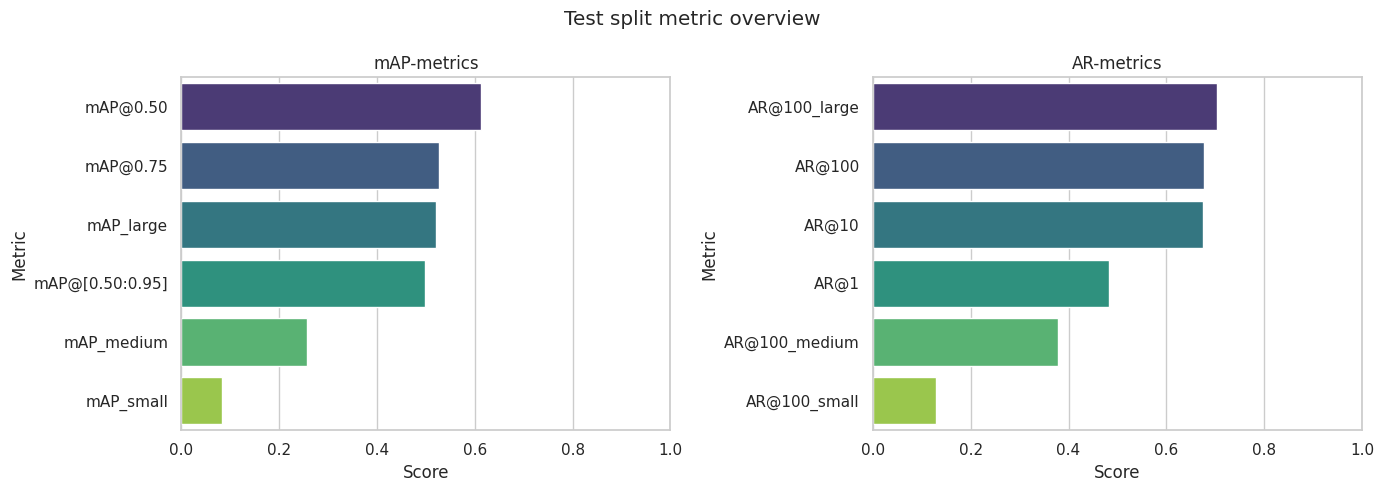

In [4]:
metric_families = []
for name in metrics_df["metric"]:
    if name.startswith("mAP"):
        metric_families.append("mAP")
    else:
        metric_families.append("AR")
metrics_df["family"] = metric_families

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)
for ax, family in zip(axes, ["mAP", "AR"], strict=False):
    subset = metrics_df[metrics_df["family"] == family]
    if subset.empty:
        ax.axis("off")
        ax.set_title(f"No {family} metrics available")
        continue
    plot = sns.barplot(
        data=subset,
        y="metric",
        x="value",
        hue="metric",
        dodge=False,
        ax=ax,
        palette="viridis",
    )
    if plot.legend_:
        plot.legend_.remove()
    ax.set_title(f"{family}-metrics")
    ax.set_xlabel("Score")
    ax.set_ylabel("Metric")
    ax.set_xlim(0, 1)
plt.suptitle("Test split metric overview")
plt.tight_layout()

In [5]:
if predictions:
    preds_df = pd.DataFrame(predictions)
    preds_df["label"] = preds_df["category_id"].map(id2label)
    preds_df["score"] = preds_df["score"].round(3)
    display(preds_df.head())
else:
    preds_df = pd.DataFrame(
        columns=["image_id", "category_id", "bbox", "score", "label"]
    )
    print("No predictions above the selected threshold.")

,image_id,category_id,bbox,score,segmentation,area,id,iscrowd,label
0,0,1,"[-0.145111083984375, 90.965087890625, 786.8592...",0.525,"[[-0.145111083984375, 90.965087890625, -0.1451...",464578.321145,1,0,Dog
1,0,1,"[-1.492095947265625, 89.20011138916016, 857.07...",0.913,"[[-1.492095947265625, 89.20011138916016, -1.49...",508337.937825,2,0,Dog
2,1,4,"[120.29740142822266, 740.353515625, 187.257713...",0.933,"[[120.29740142822266, 740.353515625, 120.29740...",27178.930133,3,0,Cattle
3,2,2,"[687.7573852539062, 132.1741485595703, 286.804...",0.771,"[[687.7573852539062, 132.1741485595703, 687.75...",99315.981540,4,0,Horse
4,2,2,"[340.5492248535156, 117.79615783691406, 512.56...",0.640,"[[340.5492248535156, 117.79615783691406, 340.5...",189860.937112,5,0,Horse


,detections
label,
Cattle,1035
Horse,726
Sheep,701
Dog,373
Cat,370
Elephant,350
Zebra,197
Bear,100
Giraffe,99


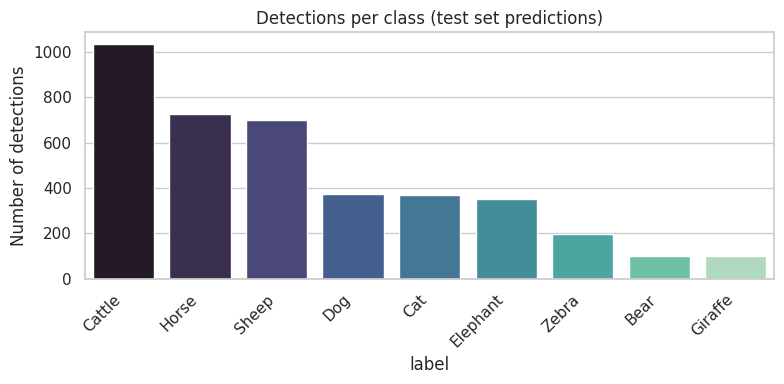

In [6]:
if not preds_df.empty:
    label_counts = (
        preds_df.groupby("label")["score"]
        .count()
        .rename("detections")
        .sort_values(ascending=False)
        .reset_index()
    )
    display(label_counts.set_index("label"))
    plt.figure(figsize=(8, 4))
    plot = sns.barplot(
        data=label_counts,
        x="label",
        y="detections",
        hue="label",
        dodge=False,
        palette="mako",
    )
    if plot.legend_:
        plot.legend_.remove()
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Number of detections")
    plt.title("Detections per class (test set predictions)")
    plt.tight_layout()
else:
    print("No detection stats to visualize.")

In [7]:
def draw_detections(
    ax, payload: dict, color_cycle: Iterable[tuple[float, float, float]] | None = None
) -> None:
    """Draw bounding boxes and labels on a Matplotlib axis."""
    image = Image.open(payload["image_path"]).convert("RGB")
    ax.imshow(image)
    ax.set_axis_off()
    boxes = payload["boxes"]
    scores = payload["scores"]
    labels = payload["labels"]
    if color_cycle is None:
        color_cycle = sns.color_palette("tab10", n_colors=max(1, len(boxes)))
    for idx, (box, score, label) in enumerate(zip(boxes, scores, labels, strict=False)):
        x0, y0, x1, y1 = box
        width = x1 - x0
        height = y1 - y0
        color = color_cycle[idx % len(color_cycle)]
        rect = patches.Rectangle(
            (x0, y0), width, height, linewidth=2, edgecolor=color, facecolor="none"
        )
        ax.add_patch(rect)
        ax.text(
            x0,
            max(y0 - 2, 0),
            f"{label} ({score:.2f})",
            color="white",
            fontsize=10,
            ha="left",
            va="bottom",
            bbox=dict(facecolor=color, alpha=0.6, edgecolor="none", pad=2),
        )
    ax.set_title(payload["image_path"].name)

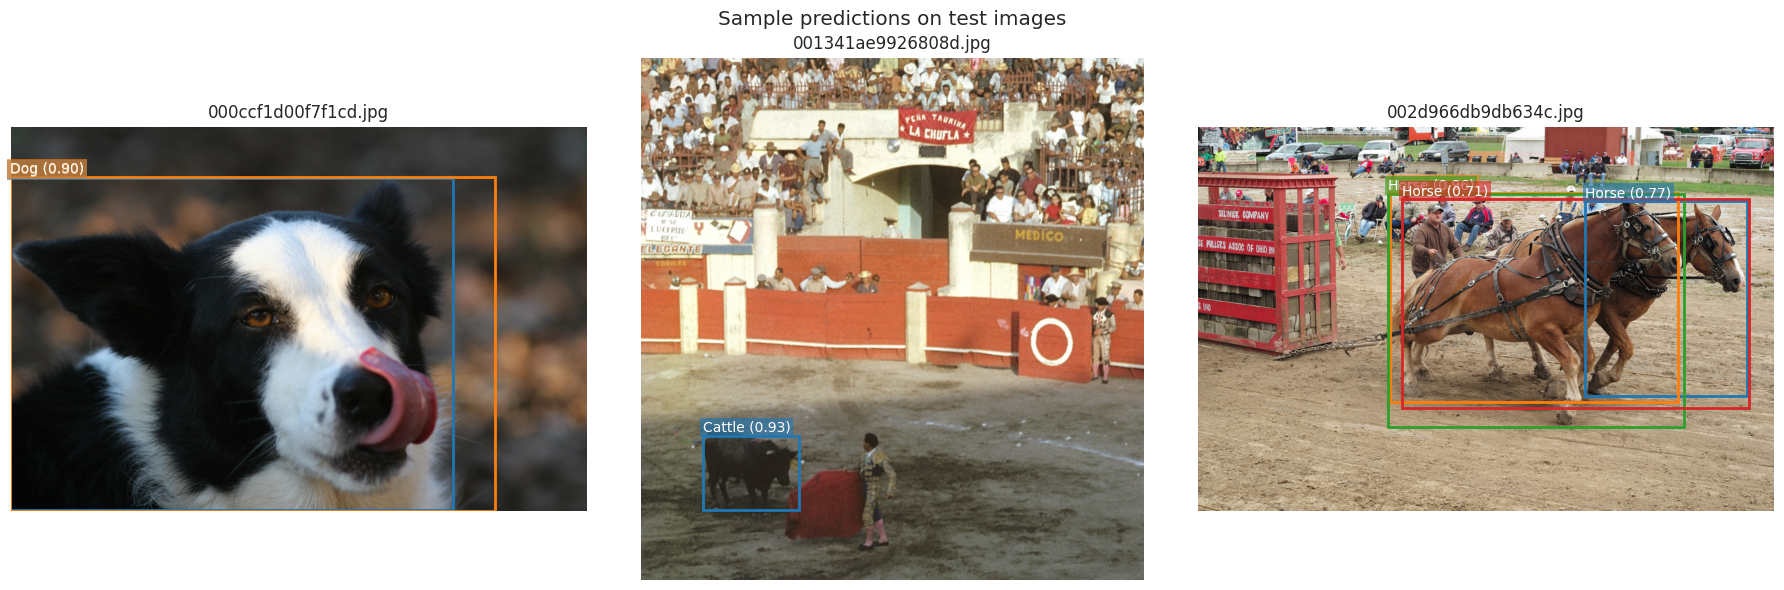

In [8]:
visual_payloads = []
example_images = sorted(TEST_IMAGES_DIR.glob("*.jpg"))[:3]
if not example_images:
    print("No test images found for visualization.")
else:
    visual_payloads = eval_utils.get_visual_predictions(
        model=model,
        processor=processor,
        id2label=id2label,
        image_paths=example_images,
        score_threshold=VISUAL_SCORE_THRESHOLD,
    )
    cols = len(visual_payloads)
    fig, axes = plt.subplots(1, cols, figsize=(6 * cols, 6))
    if cols == 1:
        axes = [axes]
    for ax, payload in zip(axes, visual_payloads, strict=False):
        draw_detections(ax, payload)
    plt.suptitle("Sample predictions on test images")
    plt.tight_layout()

In [9]:
if example_images and visual_payloads:
    detailed_rows = []
    for payload in visual_payloads:
        for box, score, label in zip(
            payload["boxes"],
            payload["scores"],
            payload["labels"],
            strict=False,
        ):
            detailed_rows.append(
                {
                    "image": payload["image_path"].name,
                    "label": label,
                    "score": round(score, 3),
                    "x_min": round(box[0], 1),
                    "y_min": round(box[1], 1),
                    "x_max": round(box[2], 1),
                    "y_max": round(box[3], 1),
                }
            )
    if detailed_rows:
        pd.DataFrame(detailed_rows)
    else:
        print("No bounding boxes above the visualization threshold.")
else:
    print("Skipping detail table; no visualizations available.")